# Brain Tumor Detector

## Definition of the Dataset

We decided to use the dataset : https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

It contains:
- 253 MRI images in total
- 98 No Tumor (38.74%)
- 155 Yes Tumor (61.26%)


## Installation and Import Packages

### Installation

In [1]:
%pip install numpy
%pip install torch
%pip install matplotlib
%pip install scikit-learn
%pip install opencv-python
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing Packages 

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import matplotlib.pyplot as plt
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2



## Reading MRI Images

This section reads and processes MRI images of brain scans. It’s divided into two parts: loading images with tumors and loading images without tumors.

In [3]:
# Load and process images from the dataset, return as numpy array
def load_and_process_images(path, size=(128, 128)):
    images = []
    for file in glob.iglob(path):
        img = cv2.imread(file)
        img = cv2.resize(img, size)
        # Convert from BGR to RGB for visualization consistency
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return np.array(images)


healthy_images = load_and_process_images('data/no/*.jpg')
infected_images = load_and_process_images('data/yes/*.jpg')

## Visualizing Brain MRI Images

The plot_images function is defined to visualize images from each category, "healthy" and "infected":

In [4]:
def plot_images(images, title):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    fig.suptitle(title)
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f'Shape: {img.shape}')
    plt.show()

The images parameter receives a random list of images of each category.

<Figure size 1600x900 with 0 Axes>

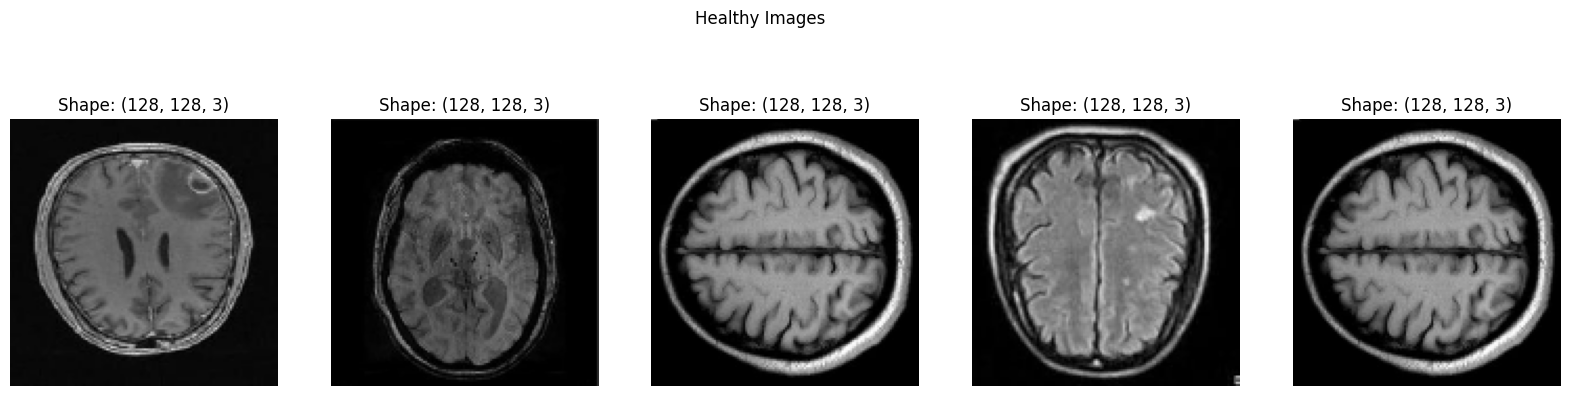

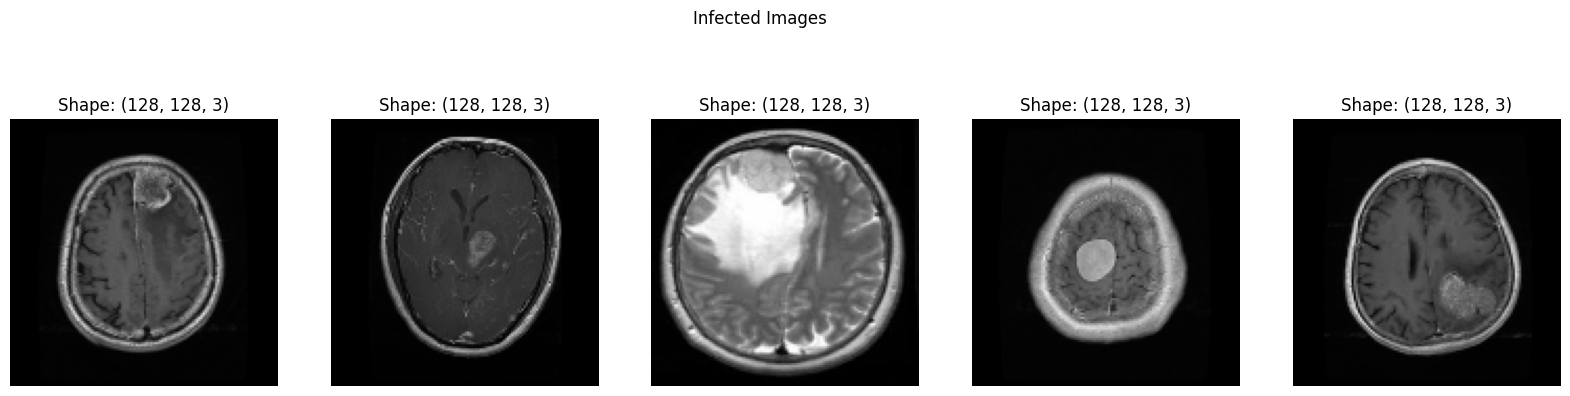

In [5]:
plt.figure(figsize=(16,9))

# Plot some healthy and infected images to visualize the data
plot_images(healthy_images[np.random.choice(healthy_images.shape[0], 5, replace=False)], 'Healthy Images')
plot_images(infected_images[np.random.choice(infected_images.shape[0], 5, replace=False)], 'Infected Images')

In [6]:
class MRIDataset(Dataset):
    def __init__(self, healthy_images, infected_images, transform=None):
        self.healthy_images = healthy_images
        self.infected_images = infected_images
        self.transform = transform
        self.labels = [0] * len(healthy_images) + [1] * len(infected_images)
        self.images = np.concatenate((healthy_images, infected_images), axis=0)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Example usage:
# Define any transformations if needed
transform = None

# Create the dataset
mri_dataset = MRIDataset(healthy_images, infected_images, transform=transform)

# Create a DataLoader for batching and shuffling
mri_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)

In [7]:
#Apply transformations for preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

mri_dataset = MRIDataset(healthy_images, infected_images, transform=transform)

In [8]:
# Split the dataset into train and test sets
data_size = len(mri_dataset)
train_size = int(0.8 * data_size) # 80% of the data is used for training
test_size = data_size - train_size # Remaining 20% is used for testing

train_dataset, test_dataset = random_split(mri_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Use Transfer Learning with Pretrained Model
class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.base_model(x)


In [10]:
# Initialize model, loss function, and optimizer
model = TransferLearningModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.base_model.fc.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/Users/cristinasemikina/Desktop/Denmark/Biomedical-Machine-Learning/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cristinasemikina/Desktop/Denmark/Biomedical-Machine-Learning/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/cristinasemikina/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


TransferLearningModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [11]:
# Training loop with Accuracy Tracking
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    train_accuracies = []
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        accuracy = correct / total
        train_accuracies.append(accuracy)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}")
    return train_accuracies

In [12]:
# Evaluation loop
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    return acc, cm

In [13]:
# Plotting Training Progress
def plot_training_progress(train_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Progress')
    plt.legend()
    plt.grid()
    plt.show()


In [14]:
# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=10)

Epoch [1/10], Loss: 0.4545, Accuracy: 0.7875
Epoch [2/10], Loss: 0.2745, Accuracy: 0.8797
Epoch [3/10], Loss: 0.2275, Accuracy: 0.8938
Epoch [4/10], Loss: 0.1900, Accuracy: 0.9250
Epoch [5/10], Loss: 0.1554, Accuracy: 0.9313
Epoch [6/10], Loss: 0.1584, Accuracy: 0.9406
Epoch [7/10], Loss: 0.1453, Accuracy: 0.9453
Epoch [8/10], Loss: 0.1032, Accuracy: 0.9750
Epoch [9/10], Loss: 0.1209, Accuracy: 0.9609
Epoch [10/10], Loss: 0.0824, Accuracy: 0.9656


[0.7875,
 0.8796875,
 0.89375,
 0.925,
 0.93125,
 0.940625,
 0.9453125,
 0.975,
 0.9609375,
 0.965625]

In [15]:
# Evaluate the model
train_accuracies = train_model(model, train_loader, criterion, optimizer, epochs=10)

Epoch [1/10], Loss: 0.0844, Accuracy: 0.9750
Epoch [2/10], Loss: 0.0563, Accuracy: 0.9844
Epoch [3/10], Loss: 0.0838, Accuracy: 0.9641
Epoch [4/10], Loss: 0.1103, Accuracy: 0.9547
Epoch [5/10], Loss: 0.0581, Accuracy: 0.9812
Epoch [6/10], Loss: 0.0631, Accuracy: 0.9781
Epoch [7/10], Loss: 0.0562, Accuracy: 0.9844
Epoch [8/10], Loss: 0.0437, Accuracy: 0.9922
Epoch [9/10], Loss: 0.0465, Accuracy: 0.9859
Epoch [10/10], Loss: 0.0631, Accuracy: 0.9734


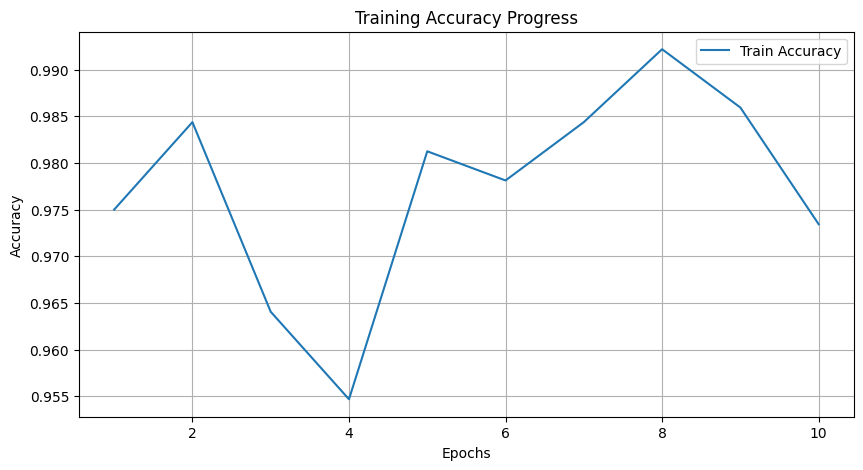

In [16]:
# Plot training progress
plot_training_progress(train_accuracies)

In [17]:
# Evaluate the model
evaluate_model(model, test_loader)

Accuracy: 0.9938
Confusion Matrix:
[[82  0]
 [ 1 77]]


(0.99375,
 array([[82,  0],
        [ 1, 77]]))